ML Olympiad Jumia Sentiment Analysis





In [2]:
import pandas as pd

In [3]:
train_df=pd.read_csv('/content/train (5).csv')
test_df=pd.read_csv('/content/test (3).csv')

In [4]:
train_df.head()

,IdCustomer,Text,Target
0,3123,Service tayara avec jumia,Positive
1,2228,"pouffe sympa et pas encombrante, belle couleur...",Neutre
2,2217,C'est ce que je voulais. Pas de mauvaise surprise,Positive
3,1334,"Très confortable, je le recommande vivement",Positive
4,4086,parfait,Positive


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3367 entries, 0 to 3366
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IdCustomer  3367 non-null   int64 
 1   Text        3367 non-null   object
 2   Target      3367 non-null   object
dtypes: int64(1), object(2)
memory usage: 105.2+ KB


In [10]:
train_df.describe()

,IdCustomer
count,3367.000000
mean,2241.032076
std,1294.439825
min,0.000000
25%,1123.500000
50%,2241.000000
75%,3344.500000
max,4489.000000


In [6]:
train_df.Target.value_counts()

Positive    2477
Negative     501
Neutre       389
Name: Target, dtype: int64

First, We'll begin with naive bayes baseline model 

In [12]:
from sklearn.model_selection import train_test_split
X=train_df.Text
y=train_df.Target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


In [11]:
model=Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('naive_bayes',MultinomialNB())
])

In [13]:
model.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('naive_bayes', MultinomialNB())])

In [14]:
preds=model.predict(X_test)

In [15]:
preds

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype='<U8')

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

    Negative       0.88      0.09      0.16       156
      Neutre       0.00      0.00      0.00       110
    Positive       0.75      1.00      0.86       745

    accuracy                           0.75      1011
   macro avg       0.54      0.36      0.34      1011
weighted avg       0.69      0.75      0.66      1011



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##USE MODEL##

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

In [19]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df.Text.to_numpy(),
                                                                            train_df.Target.to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for r

In [20]:
val_labels.shape

(337,)

In [21]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1,1))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
train_labels

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [23]:
train_labels_one_hot

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [24]:
train_labels[:5]

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive'],
      dtype=object)

In [25]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [26]:
max_tokens = 6800

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55)

In [30]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [35]:
model = tf.keras.Sequential([
  sentence_encoder_layer, 
  
  # take in sentences and then encode them into an embedding
  tf.keras.layers.Dense(128, activation="relu"),

  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(3, activation="softmax")
], name="model_USE")

# Compile model
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 256,871,939
Trainable params: 74,115
Non-trainable params: 256,797,824
_________________________________________________________________


In [36]:
model_history = model.fit(train_sentences,
                              train_labels_one_hot,
                              epochs=10,
                              validation_data=(val_sentences, val_labels_one_hot)
                              )

Epoch 1/10
95/95 [==============================] - 3s 17ms/step - loss: 0.6706 - accuracy: 0.7485 - val_loss: 0.5354 - val_accuracy: 0.8042
Epoch 2/10
95/95 [==============================] - 1s 10ms/step - loss: 0.4882 - accuracy: 0.8026 - val_loss: 0.5007 - val_accuracy: 0.8279
Epoch 3/10
95/95 [==============================] - 1s 9ms/step - loss: 0.4384 - accuracy: 0.8284 - val_loss: 0.5015 - val_accuracy: 0.8427
Epoch 4/10
95/95 [==============================] - 1s 10ms/step - loss: 0.3956 - accuracy: 0.8459 - val_loss: 0.5175 - val_accuracy: 0.8309
Epoch 5/10
95/95 [==============================] - 1s 11ms/step - loss: 0.3541 - accuracy: 0.8686 - val_loss: 0.5315 - val_accuracy: 0.8279
Epoch 6/10
95/95 [==============================] - 1s 11ms/step - loss: 0.3102 - accuracy: 0.8861 - val_loss: 0.5400 - val_accuracy: 0.8279
Epoch 7/10
95/95 [==============================] - 1s 11ms/step - loss: 0.2628 - accuracy: 0.9125 - val_loss: 0.5585 - val_accuracy: 0.8249
Epoch 8/10
95/

In [37]:
model.evaluate(val_sentences,val_labels_one_hot)

11/11 [==============================] - 0s 15ms/step - loss: 0.6787 - accuracy: 0.8338


[0.6787071228027344, 0.8338279128074646]

In [ ]:
model_6=tf.keras.models.load_model("/content/model_experiments/kaggle")
model_6.evaluate(val_sentences,val_labels)

3/3 [==============================] - 1s 25ms/step - loss: 0.3109 - accuracy: 0.8667


[0.3108673095703125, 0.8666666746139526]

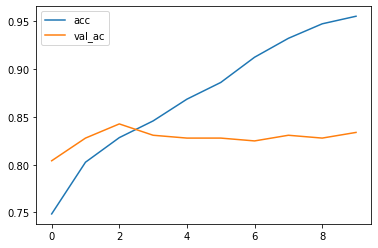

In [41]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['accuracy'],label='acc')
plt.plot(model_history.history['val_accuracy'],label='val_ac')
plt.legend()




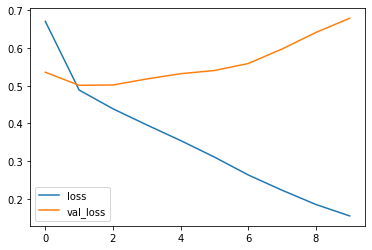

In [43]:
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='val_loss')
plt.legend()

In [44]:
test_df.head()

,IdCustomer,Text
0,3385,"pas vraiment puissante,\r\nfaisceau large"
1,605,L'odeur ne dure pas sur les vêtements et très ...
2,3983,Peut-être
3,2460,Pratique
4,4294,Pratique


In [ ]:
subm_df=pd.read_csv('/content/sample_submission (3).csv')

In [ ]:
subm_df.head()

,IdCustomer,Target
0,3385,Neutre
1,605,Neutre
2,3983,Neutre
3,2460,Neutre
4,4294,Neutre


In [ ]:
subm_df.Target.value_counts()

Neutre    1123
Name: Target, dtype: int64

In [ ]:
test_sentences=test_df.Text.to_numpy()

In [ ]:
preds_deep=tf.argmax(model.predict(val_sentences),axis=1)

11/11 [==============================] - 1s 9ms/step


In [ ]:
preds_deep

<tf.Tensor: shape=(337,), dtype=int64, numpy=
array([2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
       0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
     

In [ ]:
y_test

2396    Positive
62      Negative
1546    Positive
2887    Positive
2747    Positive
          ...   
2852    Positive
2848    Positive
1580    Positive
1168    Positive
1466    Positive
Name: Target, Length: 1011, dtype: object

In [ ]:
correct_labels=tf.argmax(val_labels_one_hot,axis=1)

In [ ]:
preds=model.predict(test_sentences)

36/36 [==============================] - 2s 26ms/step


In [ ]:
preds

array([[0.36847803, 0.47963408, 0.1518879 ],
       [0.6105323 , 0.20897539, 0.18049239],
       [0.07345585, 0.1291488 , 0.7973952 ],
       ...,
       [0.31139013, 0.04756654, 0.6410433 ],
       [0.00109595, 0.01462027, 0.9842838 ],
       [0.00899013, 0.00936268, 0.9816472 ]], dtype=float32)

In [ ]:
preds=tf.argmax(preds,axis=1)

In [ ]:
len(preds),len(subm_df)

(1123, 1123)

In [ ]:
preds

<tf.Tensor: shape=(1123,), dtype=int64, numpy=array([1, 0, 2, ..., 2, 2, 2])>

In [ ]:
subm_df['preds']=preds

In [ ]:
def pred_to_str(pred):
  if pred==0:
    return 'Negative'
  elif pred==1:
    return 'Neutre'
  else:
    return 'Positive'

In [ ]:
pred_to_str(2)

'Positive'

In [ ]:
subm_df.Target=subm_df.preds.apply(pred_to_str)

In [ ]:
subm_df.head()

,IdCustomer,Target,preds
0,3385,Neutre,1
1,605,Negative,0
2,3983,Positive,2
3,2460,Positive,2
4,4294,Positive,2


In [ ]:
val_labels

array(['Negative', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Neutre', 'Negative',
       'Positive', 'Negative', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Neutre', 'Positive', 'Neutre', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Negative', 'Positive', 'Neutre', 'Positive',
       'Positive', 'Negative', 'Positive', 'Neutre', 'Neutre', 'Positive',
       'Positive', 'Positive', 'Neutre', 'Positive', 'Positive',
       'Positive', 'Negative', 'Positive', 'Positive', 'Negative',
       'Negative', 'Negative', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Negative', 'Neutre',
       'Positive', 'Positive', 'Positive', 'Positive',

In [ ]:
val_labels_one_hot

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
final=subm_df.drop('preds',axis=1)

In [ ]:
final.head()

,IdCustomer,Target
0,3385,Neutre
1,605,Negative
2,3983,Positive
3,2460,Positive
4,4294,Positive


In [ ]:
len(final)

1123

In [ ]:
subm_df.head()

,IdCustomer,Target,preds
0,3385,Neutre,1
1,605,Negative,0
2,3983,Positive,2
3,2460,Positive,2
4,4294,Positive,2


In [ ]:
len(subm_df)

1123

In [ ]:
final.Target.value_counts()

Positive    892
Negative    158
Neutre       73
Name: Target, dtype: int64

In [ ]:
from google.colab import files
final.to_csv('subm.csv',index=False)
files.download('subm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>